## Introduction
Hi! 😉

There are a lot of notesbooks and tutorials for this digital recognizer competition. This notebook tries to summarize the various techniques out there and demonstrates the process that I learn to write my first neural network. Let's go!

## MNIST Data
Before writing the code, we need to understand the dataset. I recommend to read the data description from the contest page: [https://www.kaggle.com/c/digit-recognizer/data](http://) 

Some key points:
- For each image: height 28 pixels * width 28 pixels = 784 pixels
- Pixel value: from 0 (lightest) to 255 (darkest)
- For the whole training dataset: 785 columns
- The first column is label, the rest corresponds to one of the 784 pixels, so each row is a complete image
- To convert each image's pixel coordinate (i, j) to pixel number x (from 0 to 783), do x = i * 28 + j

Let's take a closer look to the data. If you have never tried data preprocessing, check out this course: [https://www.kaggle.com/learn/data-cleaning](http://)

In [1]:
import pandas as pd

# load data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [2]:
# take a look of first several rows of the training dataset
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# check for missing data
train.isnull().sum().sum()

0

We can see most of the pixels are white (0 in value). Thus, this dataset consists white background with black numbers (I thought it is black background). There is no missing data, so we can continue.

In [4]:
# separate label and pixels for the training set
# the testing set does not contain lables
labels = train["label"]
pureimg_train = train.drop(labels = ["label"], axis = 1) # drop the label column
del train # no longer needed

Next, we need to normalize training and testing data to make pixel value ranging from \[0, 1\], because CNN will converge faster on \[0, 1\].

In [5]:
# normalize train and test
norm_train = pureimg_train/255
norm_test = test/255

We randomly separate part of the training set as validation set. Here I choose 10% of the data to be validation set. You can choose whatever fraction you want. The reason that we can choose randomly is that the digits are evenly spread between 0 to 9. If we have an uneven amount of each digit, we cannot randomly split.

Validation set is used for hyperparameter tuning.

In [6]:
# split the training data into training and validation set
from sklearn.model_selection import train_test_split

feature_train, feature_validate, target_train, target_validate = train_test_split(norm_train, labels, test_size = 0.1, random_state = 0)

# feature: non-label part of the image
# target: what we want to get, so it is the label of the image
# we should not reshape just yet because this function defaultly separates data row wise by axis 0
# so the shape of 2D training data set array should be one image per row
# otherwise it will be separated incorrectly

In [7]:
# change data frame to numpy, and then to tensor form
# time to reshape
import numpy as np
import torch

Test = torch.from_numpy(norm_test.values.reshape((-1,1,28,28)))
featuresTrain = torch.from_numpy(feature_train.values.reshape((-1,1,28,28)))
targetsTrain = torch.from_numpy(target_train.values)
featuresValidation = torch.from_numpy(feature_validate.values.reshape((-1,1,28,28)))
targetsValidation = torch.from_numpy(target_validate.values)

## Data Augmentation
In order to have higher accuracy, we need more data. We can do data augmentation, rotation and filp of the existing images, to increase data set.

In [8]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# define batch size
batch_size = 88

In [9]:
# define own dataset
class MNISTDataset(Dataset):
    """MNIST dataset"""
    
    def __init__(self, feature, target=None, transform=None):
        
        self.X = feature
        self.y = target
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # training
        if self.transform is not None:
            return self.transform(self.X[idx]), self.y[idx]
        # testing
        elif self.y is None:
            return [self.X[idx]]
        # validation
        return self.X[idx], self.y[idx]

In [10]:
# define transform operation
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor()])

# create dataset
train_set = MNISTDataset(featuresTrain.float(), targetsTrain, transform=data_transform)
validate_set = MNISTDataset(featuresValidation.float(), targetsValidation)
test_set = MNISTDataset(Test.float())

In [11]:
# if choose not to do data augmentation
# create dataset like this, move this cell to the end of the section before data loading
train_set = torch.utils.data.TensorDataset(featuresTrain.float(), targetsTrain)
validate_set = torch.utils.data.TensorDataset(featuresValidation.float(), targetsValidation)
test_set = torch.utils.data.TensorDataset(Test.float())

In [12]:
# load the data
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validate_loader = torch.utils.data.DataLoader(validate_set, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

## CNN
We are done with data. Let's build the neural network using torch.

Network structure:
1. Convolutional(Conv2D) layer: filter=32, activation=relu
2. Convolutional(Conv2D) layer: filter=32, activation=relu
3. Max pooling layer: kernel size=2, stride=1
4. Dropout: rate=0.25
5. Convolutional(Conv2D) layer: filter=64, activation=relu
6. Convolutional(Conv2D) layer: filter=64, activation=relu
7. Max pooling layer: kernel size=2, stride=2
8. Dropout: rate=0.25
9. Flatten layer
10. Fully connected(Dense) layer
11. Dropout: rate=0.5
12. Fully connected(Dense) layer

🤔There must be a ton of questions regarding this structure.

*Q: What is a filter?* 

A: A filter performs dot product with each portion of the input image, so the portion of the most matched between input and a filter will have the highest value for the output. It means certain portion of the input contains the feature represented by the filter, so we call the output a feature map. The number of filters is the number of feature maps and the number of out channels.


*Q: What is activation?* 

A: Activation function introduces nonlinearity to the neural network. It is a function that, if the output value meets the threshold, the nueron switches on and the value is passed through, otherwise the value is not passed through.

*Q: What is an inplace relu?*

A: "Inplace" means that it will modify the input directly, without allocating any additional output. It can sometimes slightly decrease the memory usage. For this network specifically, adding inplace makes the training accuracy increases from 92 to 99.9. Weird...

*Q: What is max pooling?* 

A: Max pooling is a way of down sampling to reduce computational cost and make the feature map more robust. This operation calculates the maximum value for each patch, for example, 2\*2 here, of the feature map.

*Q: What is stride?* 

A: Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on. 

*Q: What is dropout?* 

A: During training, some number of layer outputs are randomly ignored with certain probability, for example, 0.25 and 0.5 here. Dropout regularization is for reducing overfitting and improving the generalization of deep neural networks.

*Q: What is a flattern layer?* 

A: This layer simply flattens the array into a 1-dimensional array for inputting it to the next layer.

*Q: What is a dense layer?* 

A: A dense layer is a fully connected layer. The layer performs a linear operation on the layer’s input vector.

*Q: How to calculate the dimension that goes into the first dense layer?* 

A: It is the last conv layer's out channels number times the size of 1 feature map. For this network specifically,it is 64\*3\*3.

*Q: Why do you use this structure?* 

A: This is the simpliest structure with the highest accuracy that I can find among Kaggle notebooks.

In [13]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2),
                                     nn.Dropout(0.25),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2, stride=2),
                                     nn.Dropout(0.25))
        
        self.classifier = nn.Sequential(nn.Linear(576, 256),
                                       nn.Dropout(0.5),
                                       nn.Linear(256, 10))

        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) # flatten layer
        x = self.classifier(x)
        
        return x

In [14]:
import torch.optim as optim

# defining the model
model = CNNModel()

# set optimizer, loss function, and learning rate reduction
# all these parameter comes from the first notebook in citation, the author explains the reason of choosing well
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

criterion = nn.CrossEntropyLoss()

lr_reduction = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.00001)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

## Training and Evaluation

In [15]:
# for visualization
count = 0
loss_list = []
iteration_list = []
average_training_accuracy = []
average_validation_accuracy = []
average_training_loss = []
average_validation_loss = []

In [16]:
from torch.autograd import Variable

def train(epoch):
    # print('Epoch ', epoch) # uncomment me to show verbose
    global count
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            count += 1
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, (batch_idx + 1) * len(data), len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item())) # uncomment me to show verbose

In [17]:
import torch.nn.functional as F

def evaluate(data_loader, validate=False):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    accuracy = 100. * correct / len(data_loader.dataset)
    
    if not validate:
        lr_reduction.step(loss)
        average_training_accuracy.append(accuracy)
        average_training_loss.append(loss)
        # print('Average training loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(loss, correct, len(data_loader.dataset), accuracy)) # uncomment me to show verbose
    else:
        average_validation_accuracy.append(accuracy)
        average_validation_loss.append(loss)
        # print('Average validation loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(loss, correct, len(data_loader.dataset), accuracy)) # uncomment me to show verbose

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


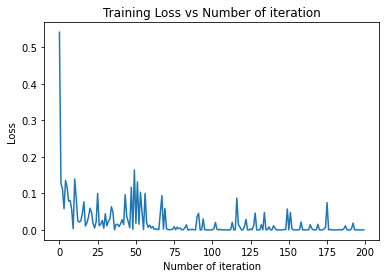

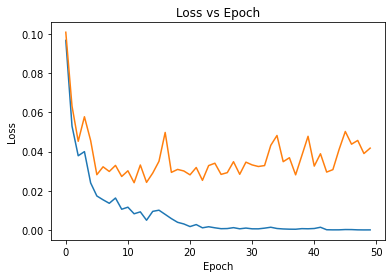

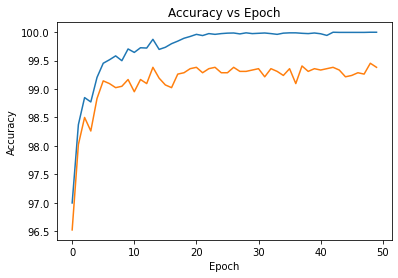

In [18]:
import matplotlib.pyplot as plt

n_epochs = 50
# without data augmentation reaches 99.3, with augmentation reaches 99.2

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)
    evaluate(validate_loader, True)
    
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Training Loss vs Number of iteration")
plt.show()

epoch_list = [i for i in range(n_epochs)]

plt.plot(epoch_list, average_training_loss)
plt.plot(epoch_list, average_validation_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

plt.plot(epoch_list, average_training_accuracy)
plt.plot(epoch_list, average_validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.show()

## Prediction

In [19]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        
        data = Variable(data[0])
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

test_pred = prediciton(test_loader)

## Submission

In [20]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_set)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# check prediction makes sense
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [21]:
out_df.to_csv('submission.csv', index=False)

If this notebook helps you, please upvote and tell me!❤️
If you have any question or there is a bug, please tell me!🤔
I will continue to make notebooks and learn with you😉

## Citation
- Notebook CNN with PyTorch (0.995 Accuracy) [https://www.kaggle.com/juiyangchang/cnn-with-pytorch-0-995-accuracy](http://)
- Notebook from Yassine Ghouzam, PhD, Introduction to CNN Keras - 0.997 (top 6%) [https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6](http://)
- Notebook Pytorch Tutorial for Deep Learning Lovers [https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers](http://)
- How Do Convolutional Layers Work in Deep Learning Neural Networks? [https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/#:~:text=Convolutional%20layers%20are%20the%20major,that%20results%20in%20an%20activation.&text=The%20result%20is%20highly%20specific,detected%20anywhere%20on%20input%20images.](http://)
- A Gentle Introduction to Pooling Layers for Convolutional Neural Networks [https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/](http://)
- A Gentle Introduction to Dropout for Regularizing Deep Neural Networks [https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/](http://)
- Determining size of FC layer after Conv layer in PyTorch [https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch](http://)